In [1]:
%cd /content/drive/My Drive/Wave_propogation

/content/drive/My Drive/Wave_propogation


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import pickle
import os
from moviepy.editor import ImageSequenceClip
import time
import torch
from PIL import Image
import torchvision.transforms as transforms

%load_ext autoreload
%autoreload 2

In [4]:
!pip install GPUtil

Defaulting to user installation because normal site-packages is not writeable
  Created wheel for GPUtil: filename=GPUtil-1.4.0-py3-none-any.whl size=7411 sha256=0f87ca35315dc2268b14552b997f670f67bbbed581b7866b9c26909e198d5d09
  Stored in directory: /home/athlete/.cache/pip/wheels/ba/03/bb/7a97840eb54479b328672e15a536e49dc60da200fb21564d53
Successfully built GPUtil


In [6]:
!python3 conv_gru.py

1 torch.Size([1, 10, 32, 6, 6])
torch.Size([1, 32, 6, 6])


In [7]:
nx = 60 # number of grid points in the horizontal direction
nz = 60 # number of grid points in the vertical direction
dd = 5.0 # grid cell size
nt = 200 # number of time samples to be modeled
dt = 0.0005 # time step
srcx = 20 # source horizontal location in meters
srcz = 10 # source vertical location in meters

nabs = int( min(nx, nz) * 0.1 ) #40 # number of absorbing cells on the boundary
a = 0.0053 # strength of sponge layer
FreeSurf=False # free surface condition of top (False for now)

In [8]:
class Simulation(object):
  def __init__(self, nx, nz, dd, nt, dt, srcx, srcz, 
               nabs, a, FreeSurf, vp, wav):
    self.nx = nx # number of grid points in the horizontal direction
    self.nz = nz # number of grid points in the vertical direction

    self.dd = dd # grid cell size
    self.nt = nt # number of time samples to be modeled
    self.dt = dt # time step

    self.srcx = srcx # source horizontal location in meters
    self.srcz = srcz # source vertical location in meters

    self.nabs = nabs # number of absorbing cells on the boundary
    self.a = a # strength of sponge layer
    self.FreeSurf = FreeSurf # free surface condition of top (False for now)

    self.vp = vp

    self.time = np.linspace(0, nt * dt, nt) # time vector

    self.wav = wav
    
    size = (self.vp.shape[0], self.vp.shape[1], self.wav.shape[0])
    self.field2d = np.zeros(size, dtype=np.float) # define variables  - field2d is output wavefield
    # self.set_source_matrixes()
    self.gen_absorb()

  def update_params(self):
    self.nabs = int( min(self.nx, self.nz) * 0.1 )
    self.time = np.arange(0, nt*dt, dt) # time vector
    size = (self.vp.shape[0], self.vp.shape[1], self.wav.shape[0])
    self.field2d = np.zeros(size, dtype=np.float) # define variables  - field2d is output wavefield
    # self.set_source_matrixes()
    self.gen_absorb()


  def get_source(self, i):
    srci = int(self.srcx / self.dd) # find where source is located on the grid
    srcj = int(self.srcz/self.dd)
    return (srci, srcj, self.wav[i])


  
  def gen_absorb(self):
    absorb = np.ones((self.nx,self.nz))
    abs_coefs = np.zeros(self.nabs)
    abs_coefs = np.exp(-(self.a**2 * (self.nabs-np.arange(self.nabs))**2))
    absorb[:self.nabs,:] = absorb[:self.nabs,:]*np.expand_dims(abs_coefs,1)
    absorb[-self.nabs:,:] = absorb[-self.nabs:,:]*np.expand_dims(abs_coefs[::-1],1)
    absorb[:,-self.nabs:] = absorb[:,-self.nabs:]*abs_coefs[::-1]
    if(self.FreeSurf==False):
        absorb[:,:self.nabs] = absorb[:,:self.nabs]*abs_coefs
    self.absorb = absorb


  def comp_deriv(self, p):
    pdx2 = np.zeros(p.shape)
    pdz2 = np.zeros(p.shape)

    pdx2[1:-1,1:-1] = (p[2:,1:-1]-2*p[1:-1,1:-1]+p[:-2,1:-1])/(self.dd**2)
    pdz2[1:-1,1:-1] = (p[1:-1,2:]-2*p[1:-1,1:-1]+p[1:-1,:-2])/(self.dd**2)
    return pdx2, pdz2


  def fd_ac(self):
    srci = int(self.srcx / self.dd) # find where source is located on the grid
    srcj = int(self.srcz/self.dd)
    
    self.srci = srci
    self.srcj = srcj

    nx, nz = self.vp.shape # infer shapes
    #nt = self.nt #self.wav.shape[0]
 
    
    p = np.zeros((nx, nz), dtype=np.float) # these are pressures at current, prev and next steps
    ppast = np.zeros((nx, nz), dtype=np.float)
    pfut = np.zeros((nx, nz), dtype=np.float)
    
    vp2 = self.vp**2 # square of velocity for easier computation
    # absorb = self.gen_absorb # generate absorbing mask
    
    for i in range(nt): # main loop
        pdx2, pdz2 = self.comp_deriv(p) # compute pressure derivatives

        pfut = 2*p + vp2*dt**2 * (pdx2 + pdz2) - ppast # compute future pressure from current and prev 

        pfut[srci, srcj] = pfut[srci,srcj] + self.wav[i] / self.dd**2 * self.dt ** 2 # inject source term at selected point
        
        p *= self.absorb # apply absorbing mask
        pfut *= self.absorb # apply absorbing mask

        self.field2d[:, :, i] = p  # save current pressure in output array

        ppast = p # redefine arrays moving to next step
        p = pfut

  def get_input(self, i):
    dict_inp = {}
    dict_inp['source'] = self.get_source(i) # return index_x, index_z, wav[i]
    dict_inp['vp'] = self.vp #
    dict_inp['dd'] = self.dd
    dict_inp['dt'] = self.dt 
    dict_inp['absorb'] = self.absorb #
    dict_inp['p'] = self.field2d[:, :, i] #

    return dict_inp

    

    

In [39]:
from scipy.ndimage import gaussian_filter
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

marm_size = 141

imsize = (nx, nz)
loader = transforms.Compose([transforms.RandomCrop(int(marm_size * 0.8)),
                             transforms.Resize(imsize),  # scale imported image
                             transforms.ToTensor()])

def rgb2gray(rgb):

    r, g, b = rgb[0,:,:], rgb[1,:,:], rgb[2,:,:]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b

    return gray

def image_loader(image_name):
    image = Image.open(image_name)
    # fake batch dimension required to fit network's input dimensions
    
    image = loader(image)#.unsqueeze(0)
    # image = rgb2gray(image)#.unsqueeze(0).unsqueeze(0)

    return image#.to(device, torch.float)

def get_vp(path_img='./images_vp/'):
  list_img = os.listdir(path_img)
  indx = np.random.randint(low=0, high=len(list_img))
 
  img_tensor = image_loader(path_img+list_img[indx])
  img_tensor = rgb2gray(img_tensor)
  img_tensor = img_tensor.numpy()
  img_tensor = img_tensor / img_tensor.max()
  img_tensor = img_tensor * np.random.randint(low=2000, high=10000)
  img_tensor = np.clip(img_tensor, 100, 10000)
  img_tensor = gaussian_filter(img_tensor, sigma=3)
  
  return img_tensor


In [40]:
def plot_snapshots(snapshot_list, col_num: int = 3, figsize=(15, 10)):
  plt.figure(figsize=figsize)
  for i in range(len(snapshot_list)):
      plt.subplot(np.ceil(len(snapshot_list) / col_num), col_num, i + 1)
      plt.axis('off')
      plt.imshow(snapshot_list[i], cmap=plt.cm.BuPu, interpolation='nearest')

In [41]:


# vp = np.arange(2000,4500,(4500-2000)/nz)
# vp = np.tile(np.expand_dims(vp,0),[nx,1]) # just coming up with a velocity model
vp = get_vp()
#vp = np.ones((nx,nz))*3000.0

time_vec = np.linspace(0, nt * dt, nt) # time vector
f0 = 15. # central frequency of the wavelet
t0 = 1/f0 # a shift to make sure wavelet is causal
scale = 1.#1e+7
wav  = scale * (1.0-2.0*np.power(np.pi*f0*(time_vec-t0),2))*np.exp(-np.power(np.pi*f0*(time_vec-t0),2)) # computing the wavelet

Simulator = Simulation(nx, nz, dd, nt, dt, srcx, srcz, nabs, a, FreeSurf, vp, wav)

In [42]:
start_seconds = time.time()
Simulator.fd_ac()
end_seconds = time.time()
print(end_seconds - start_seconds)

0.049163818359375


In [43]:
# Simulator.field2d.max()

In [44]:
# s = Simulator.get_input(0)

In [45]:

# tr = Simulator.get_input_and_label(0)
# tr['input'].shape
# tr['label'].shape

In [73]:
def get_rand_a():
  sigma = np.random.choice(np.array([5, 10, 15, 20]))
  return 1/(2*sigma**2)

def get_rand_src(dd, n, nabs):
  
  return np.random.uniform(low = (dd * n) * nabs / n, high = (dd * n) * (1 - nabs / n))

def get_rand_wav(nt, dt, f0):
  time_vec = np.linspace(0, nt * dt, nt) # time vector
  # f0 = np.random.choice(np.array([25, 30])) # central frequency of the wavelet
  t0 = 1/f0 # a shift to make sure wavelet is causal
  scale = 1.#1e+7
  wav  = scale * (1.0-2.0*np.power(np.pi*f0*(time_vec-t0),2))*np.exp(-np.power(np.pi*f0*(time_vec-t0),2)) # computing the wavelet
  return wav#, f0

def get_rand_dd(vp_min, f0, N_lam_low = 4 , N_lam_high = 6):
  # return np.random.randint(low=5, high=20)
  return np.random.uniform(low = vp_min / (f0 * N_lam_high), high = vp_min / (f0 * N_lam_low))

def get_rand_dt(dd, max_vp):
  return np.random.uniform(low = dd / max_vp / np.sqrt(2) / 5, 
                           high = dd / max_vp / np.sqrt(2))

In [74]:
def get_batch(batchsize = 20):
  batch_sols = []
  batch_target = []
  initial_features = []
  
  for b in range(batchsize):
    Simulator.a = get_rand_a()
    Simulator.vp = get_vp()
    f0 = np.random.choice(np.array([25, 30]))
    Simulator.dd = get_rand_dd(Simulator.vp.min(), f0)
    
  
    Simulator.dt = get_rand_dt(Simulator.dd, Simulator.vp.max())
    Simulator.srcx = get_rand_src(Simulator.dd, Simulator.nx, Simulator.nabs)
    Simulator.srcz = get_rand_src(Simulator.dd, Simulator.nz, Simulator.nabs)
    Simulator.wav = get_rand_wav(Simulator.nt, Simulator.dt, f0)
    #Simulator.nt = 200
    # print(Simulator.wav.shape)
    Simulator.update_params()
    
    # print(Simulator.nt)
    Simulator.fd_ac()
    # print(Simulator.field2d.shape)
    Simulator.field2d = Simulator.field2d.transpose((2, 0, 1))# * 1e+8
    #print(Simulator.field2d.shape)
    batch_target.append(np.array(Simulator.field2d[1: ]))

    Simulator.field2d[:, Simulator.srci, Simulator.srcj] += Simulator.wav * Simulator.dt**2 / Simulator.dd**2
    batch_sols.append(np.array(Simulator.field2d[: -1]))
    #print(batch_sols[-1].shape)
    initial_features.append(np.array(np.stack((Simulator.vp,  Simulator.absorb))))

  return np.stack(batch_sols), np.stack(initial_features), np.stack(batch_target), Simulator.dd, f0


In [75]:
# import os
# import numpy as np
# from moviepy.editor import ImageSequenceClip
# #Installation instructions: 
# #    pip install numpy
# #    pip install moviepy
# #    Moviepy needs ffmpeg tools on your system
# #        (I got mine with opencv2 installed with ffmpeg support)

# def create_gif(filename, array, fps=10, scale=1.0):
#     """creates a gif given a stack of ndarray using moviepy
#     Parameters
#     ----------
#     filename : string
#         The filename of the gif to write to
#     array : array_like
#         A numpy array that contains a sequence of images
#     fps : int
#         frames per second (default: 10)
#     scale : float
#         how much to rescale each image by (default: 1.0)
#     """
#     fname, _ = os.path.splitext(filename)   #split the extension by last period
#     filename = fname + '.gif'               #ensure the .gif extension
#     if array.ndim == 3:                     #If number of dimensions are 3, 
#         array = array[..., np.newaxis] * np.ones(3)   #copy into the color 
#                                                       #dimension if images are 
#                                                       #black and white
#     clip = ImageSequenceClip(list(array), fps=fps).resize(scale)
#     clip.write_gif(filename, fps=fps)
#     return clip

# randomimage = np.random.randn(100, 64, 64)       
# create_gif('test.gif', randomimage)                 #example 1

# myimage = np.ones(shape=(300, 200))
# myimage[:] = 25
# myimage2 = np.ones(shape=(300, 200))
# myimage2[:] = 85
# arrayOfNdarray = np.array([myimage, myimage2])

# create_gif(filename="grey_then_black.gif",          #example 2
#            array=arrayOfNdarray, 
#            fps=5, 
#            scale=1.3)

5.418452256630638


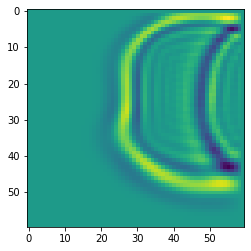

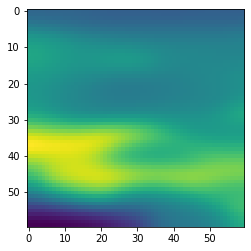

5.0206832190718576


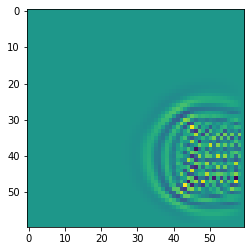

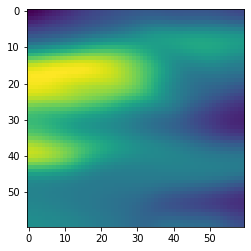

4.865906267740078


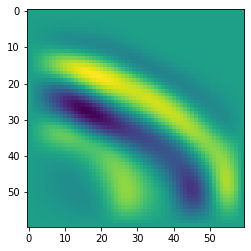

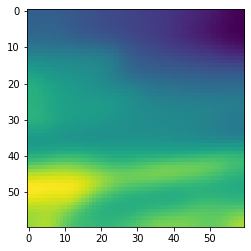

4.065764510165904


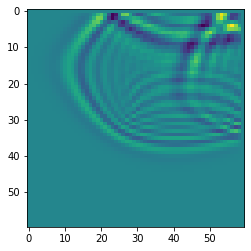

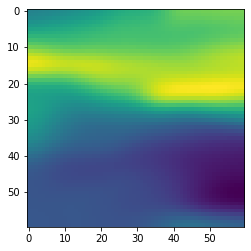

4.799989886666828


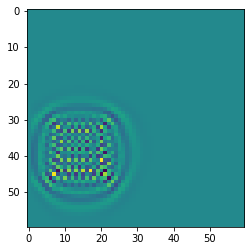

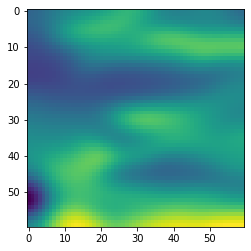

5.8665763819377945


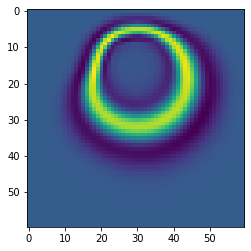

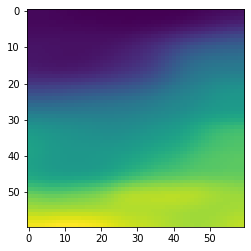

5.974445809703709


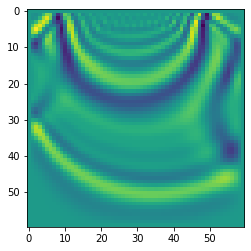

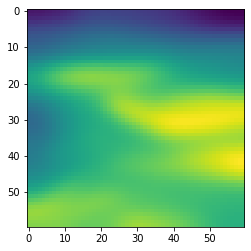

4.637763698144329


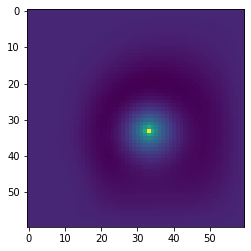

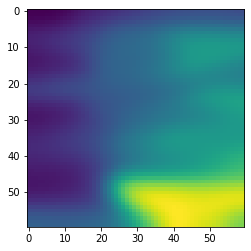

4.488635922328116


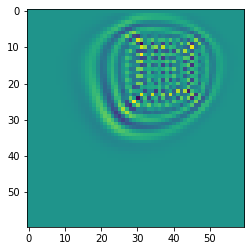

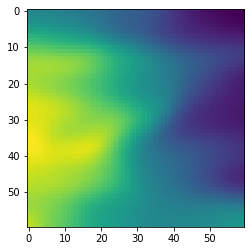

5.695694286925643


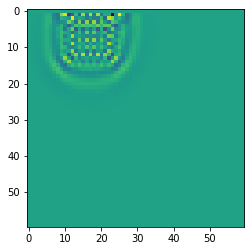

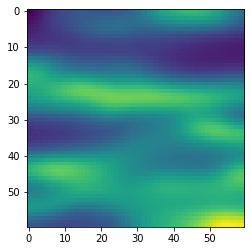

4.6652183867285


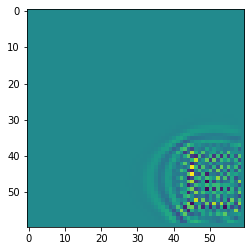

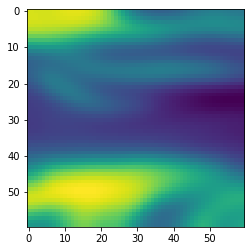

4.465749021320995


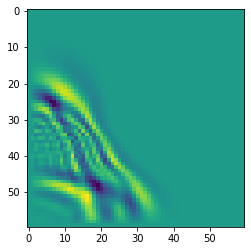

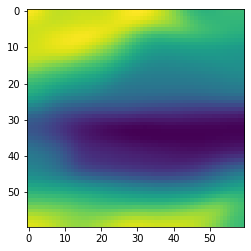

4.812505696841391


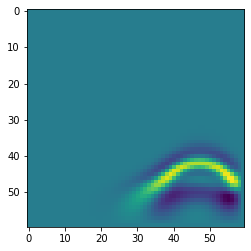

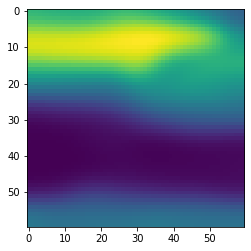

4.917141875516536


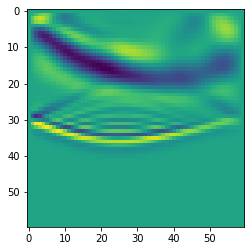

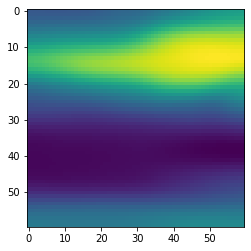

5.422865738840239


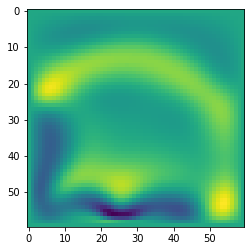

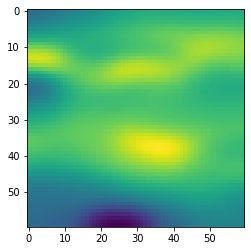

5.899851908101786


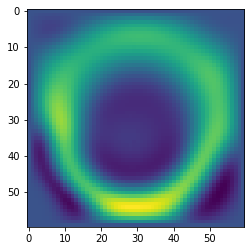

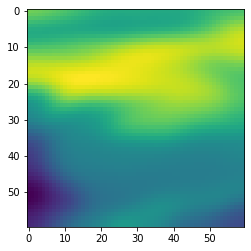

4.125952459733225


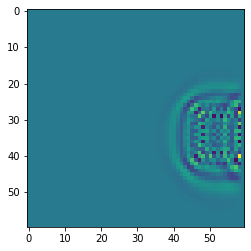

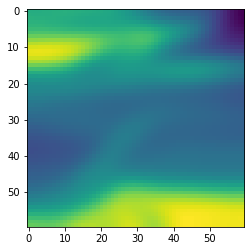

5.794939506163897


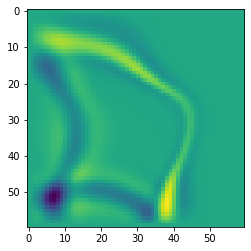

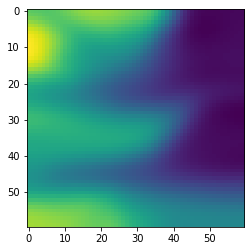

4.178517559423329


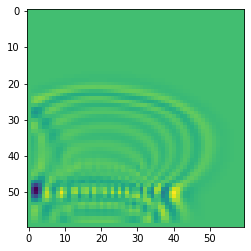

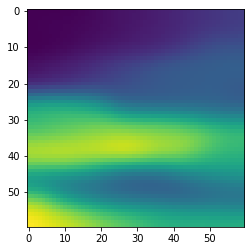

4.462167746368045


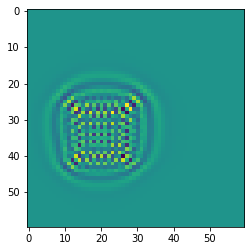

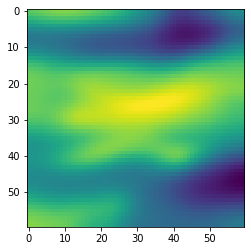

4.305414564627637


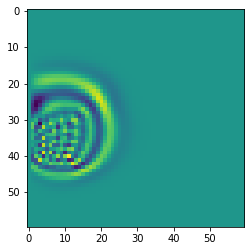

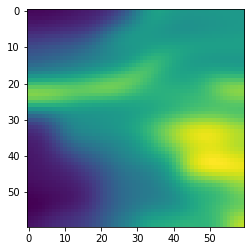

4.091081699321768


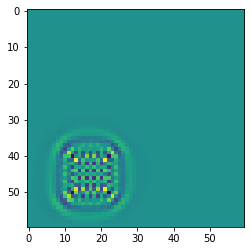

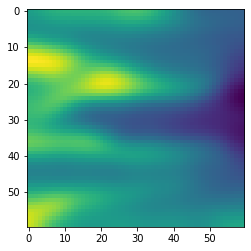

4.12902328712757


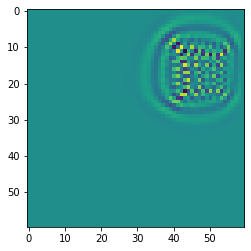

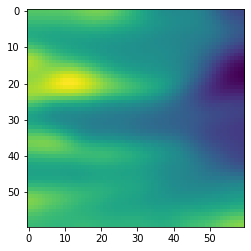

4.313522522510613


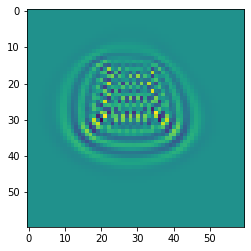

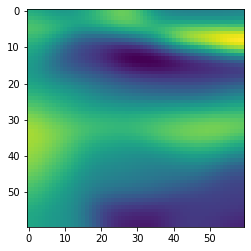

5.990633845964844


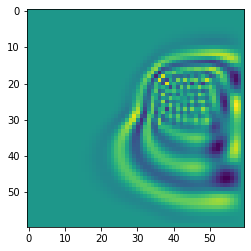

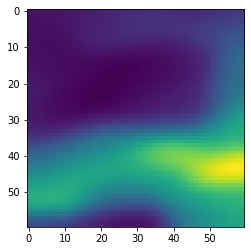

5.584282667056476


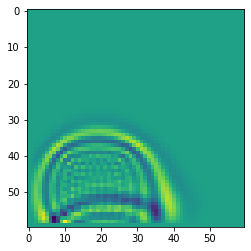

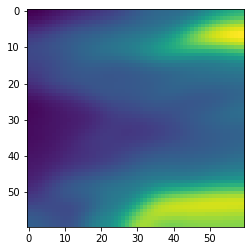

5.2342368112842195


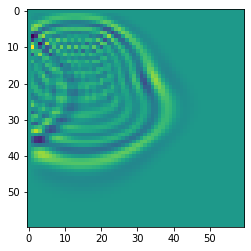

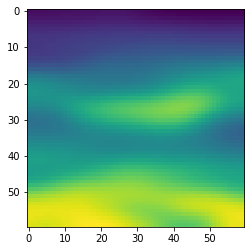

5.775400279199181


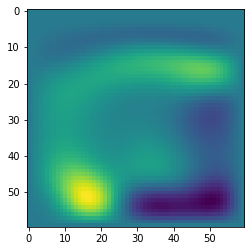

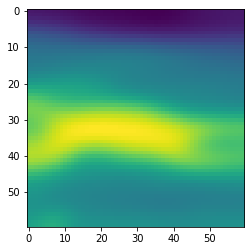

4.261086150783961


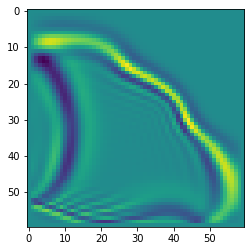

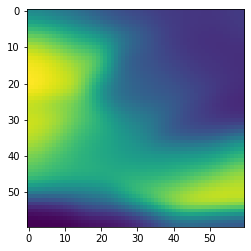

5.226193219670432


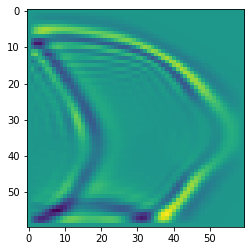

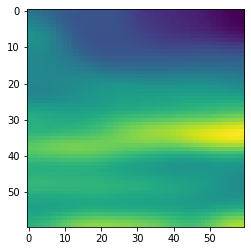

4.151927197716019


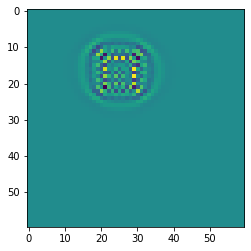

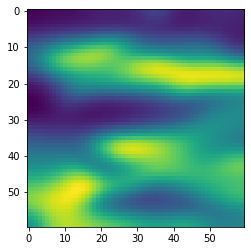

5.373846515869593


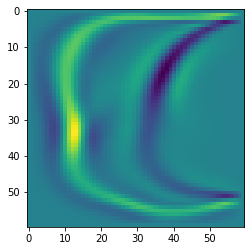

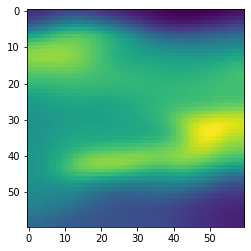

4.077300367429866


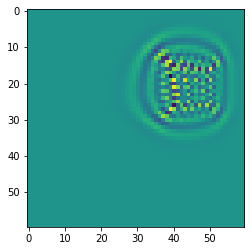

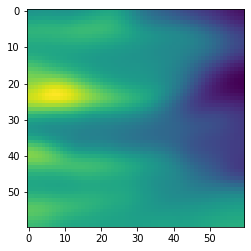

4.133071321471025


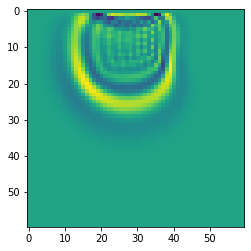

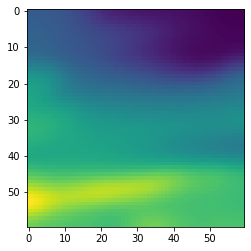

4.210019286562256


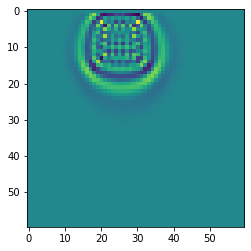

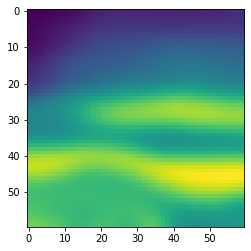

4.874417593608358


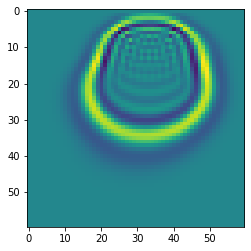

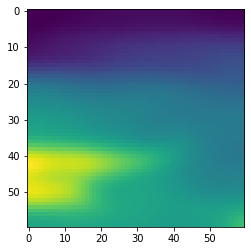

4.502855490569042


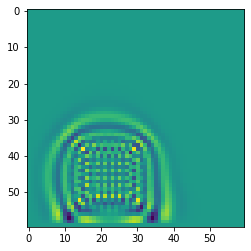

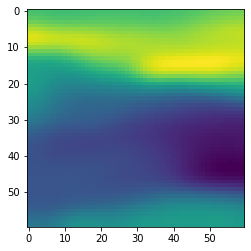

5.66475793159648


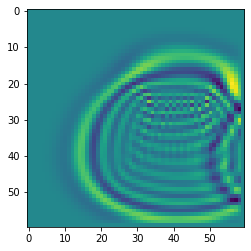

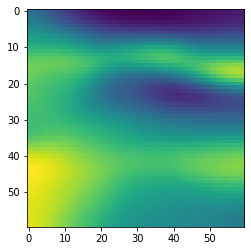

4.813995847220231


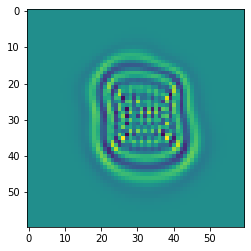

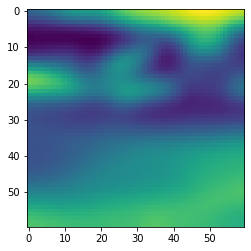

4.340987013487137


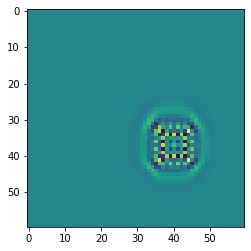

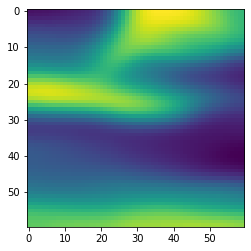

5.419537341461831


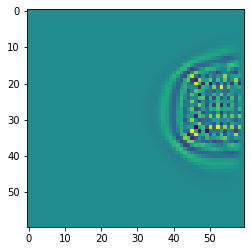

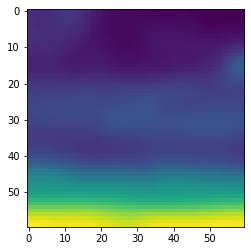

4.077006129439567


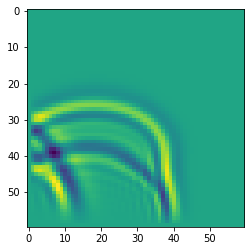

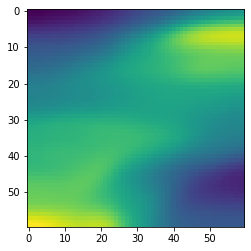

4.269399285649848


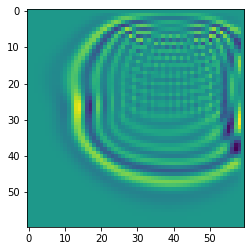

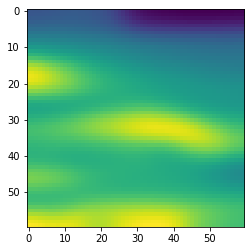

5.135657758571113


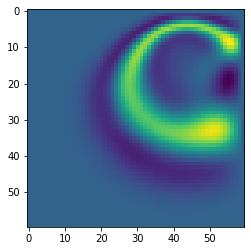

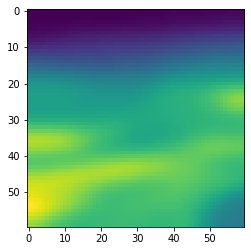

4.409418139820671


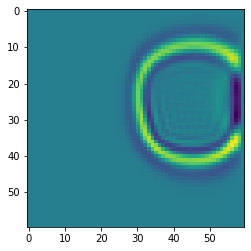

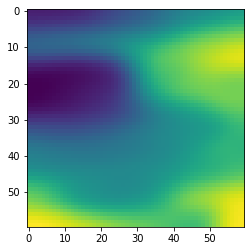

5.338094793240556


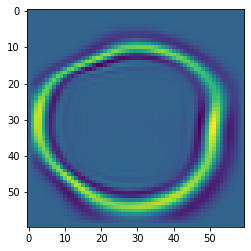

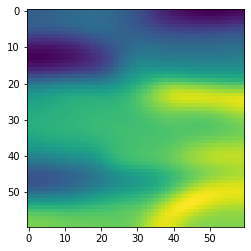

5.4315350922019805


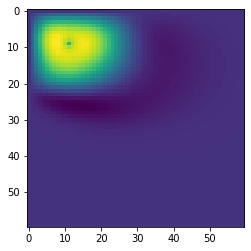

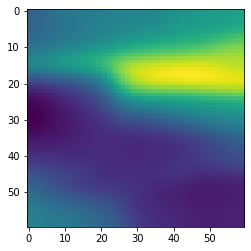

5.9061340119162455


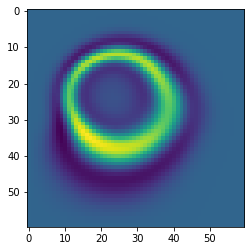

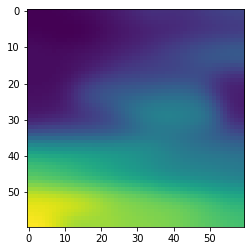

4.744733506665039


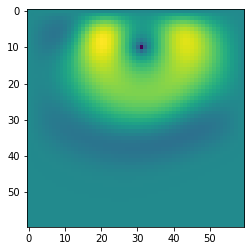

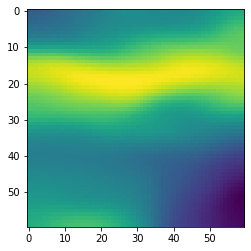

4.118600232701408


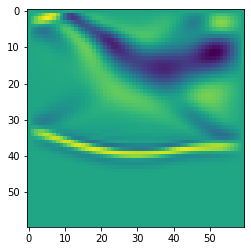

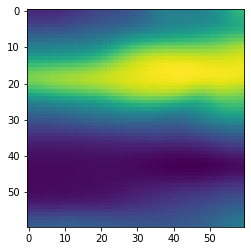

5.273768941561009


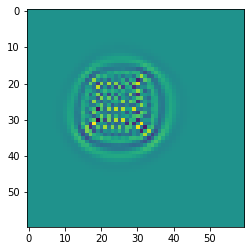

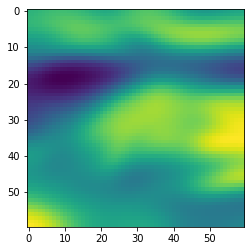

5.577007370078366


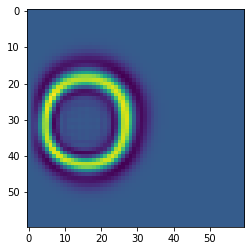

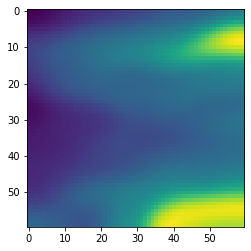

4.747162723950262


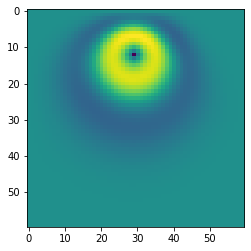

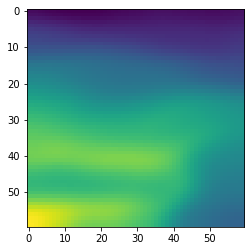

5.426065025516261


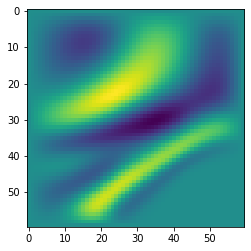

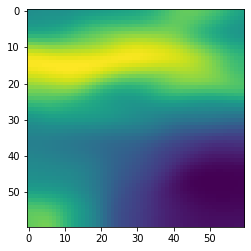

4.786371068793093


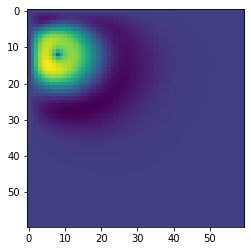

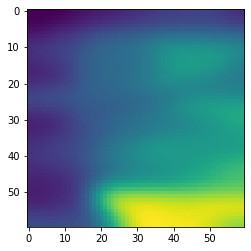

5.400030982948757


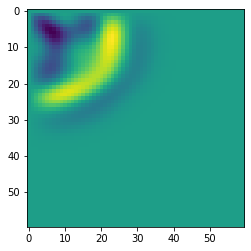

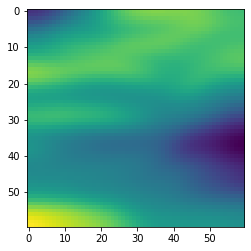

5.462912636914497


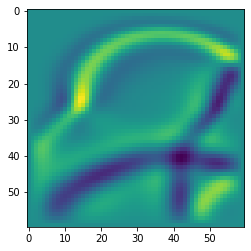

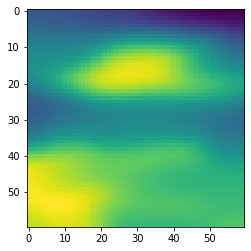

5.185062135591894


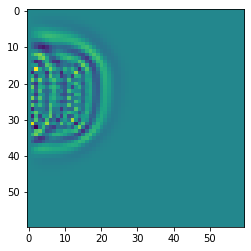

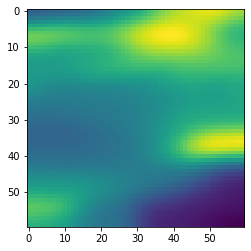

5.585004390912408


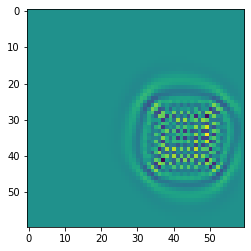

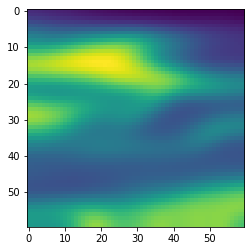

5.6871868260396194


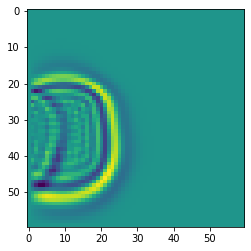

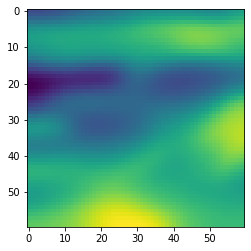

4.634599534177961


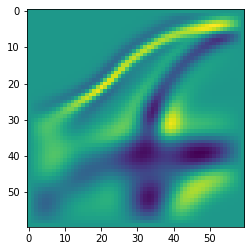

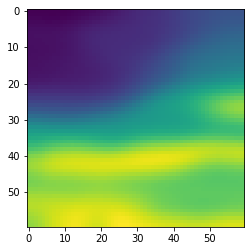

4.071935878000325


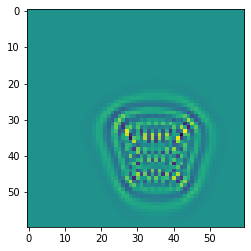

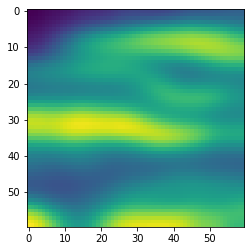

5.562570478698035


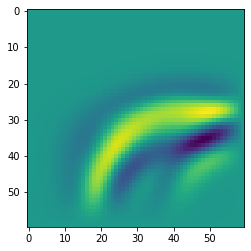

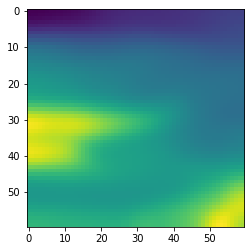

4.734004948000157


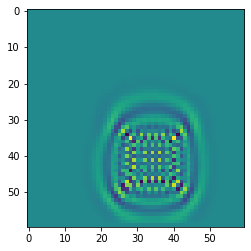

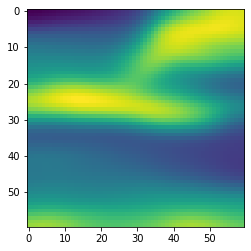

4.816909059825359


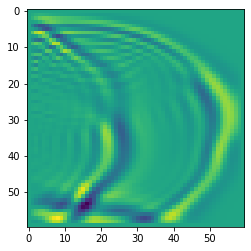

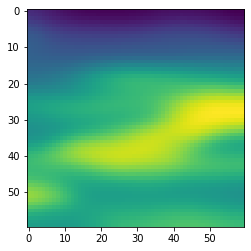

4.226749848955211


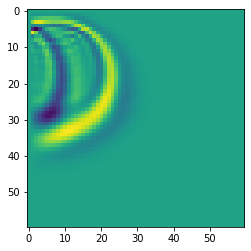

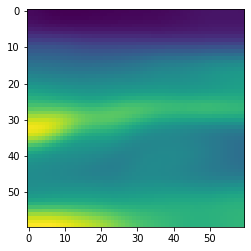

4.347105772398514


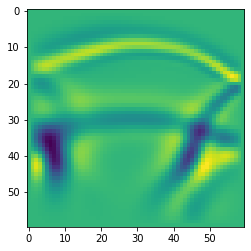

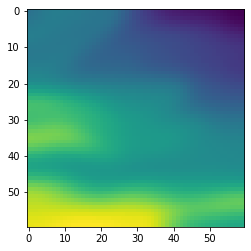

5.998482533063353


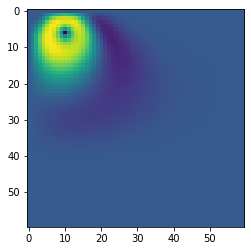

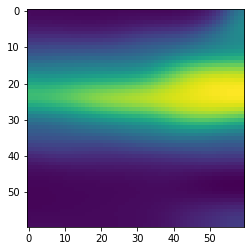

4.228626315466052


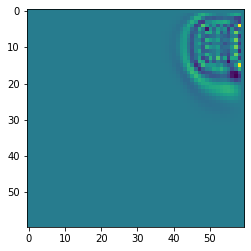

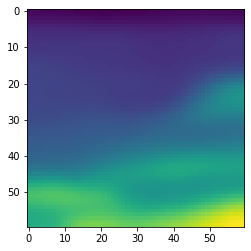

4.546194060442017


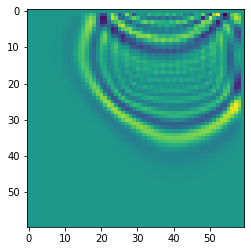

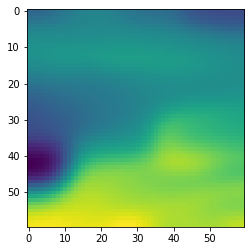

4.510085893165696


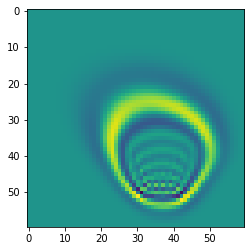

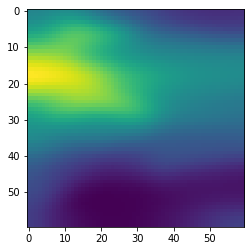

5.668376110073729


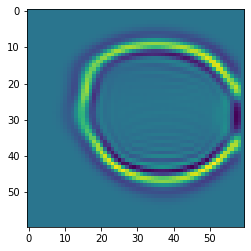

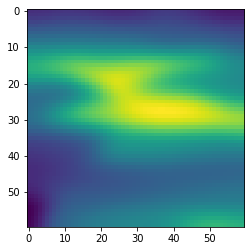

5.167064589103895


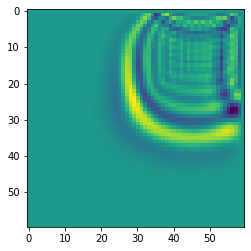

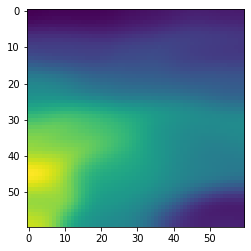

4.423306440873702


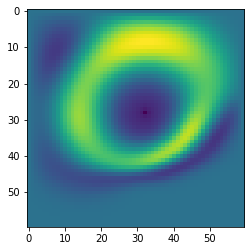

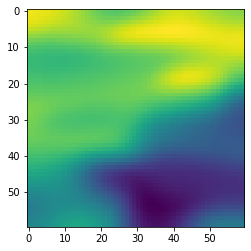

5.602937521360978


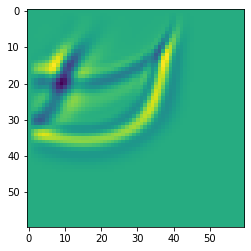

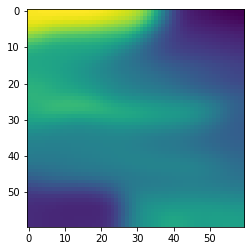

4.813381384884976


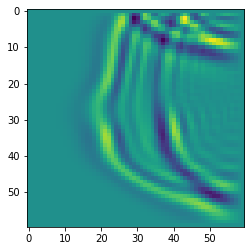

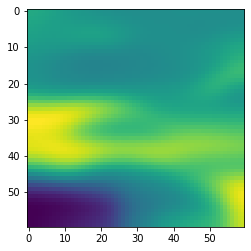

4.99463790388289


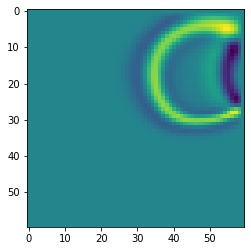

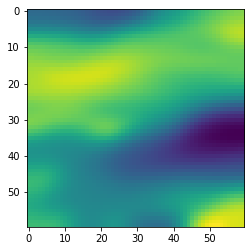

4.37634656350392


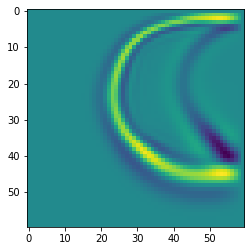

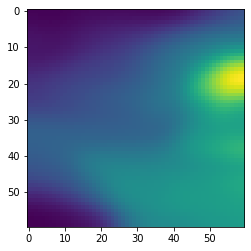

5.335073082004852


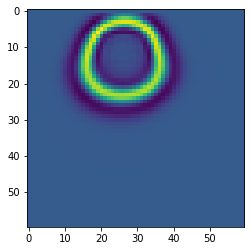

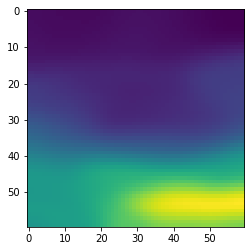

4.4842280305427655


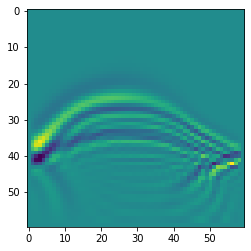

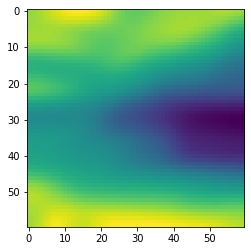

4.459195782616652


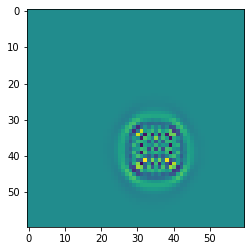

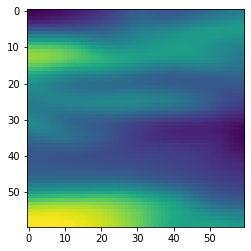

4.111578859247476


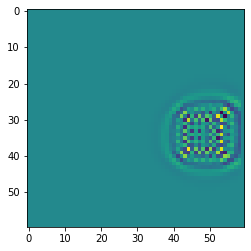

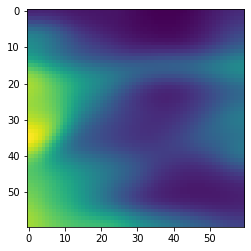

4.668285892047873


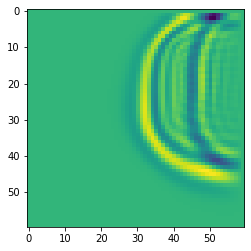

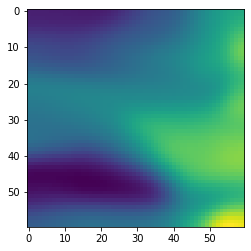

5.869275763706677


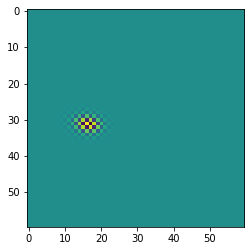

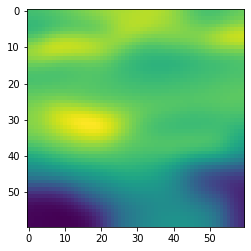

4.521207640656876


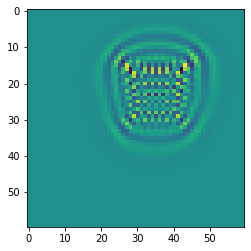

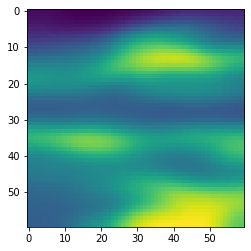

4.144441131259752


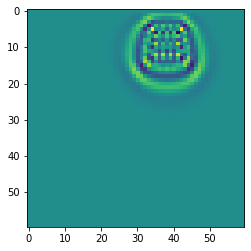

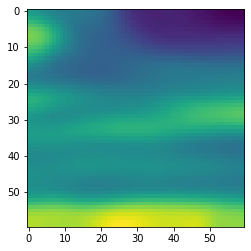

4.753258539820829


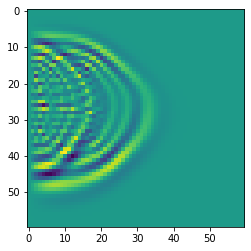

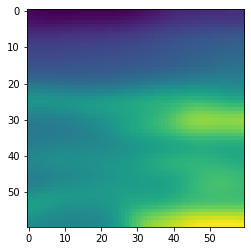

4.000391869834808


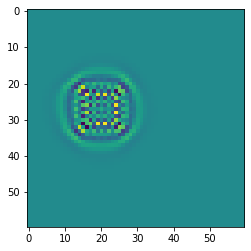

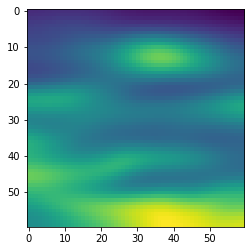

5.702636143762478


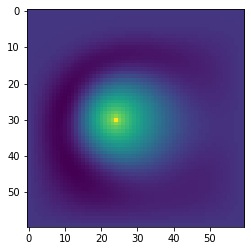

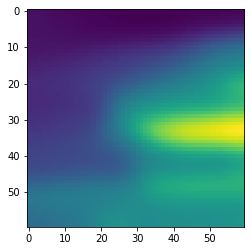

4.790084899608831


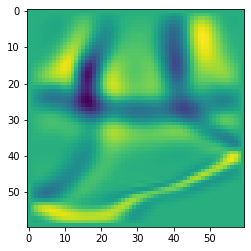

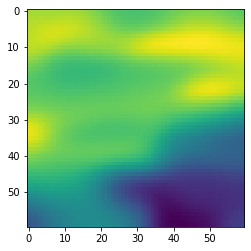

4.109502618773863


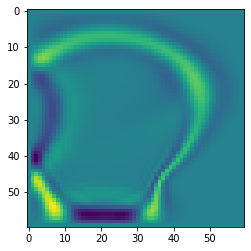

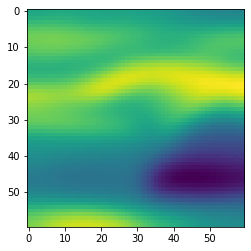

4.352583809749042


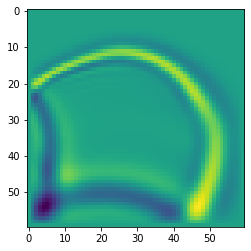

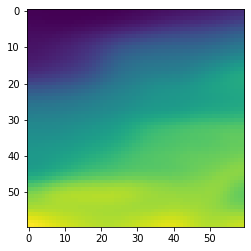

4.071855331387878


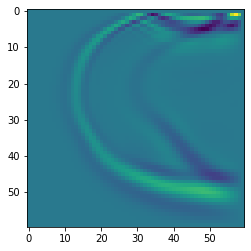

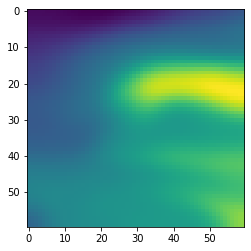

5.178762861711139


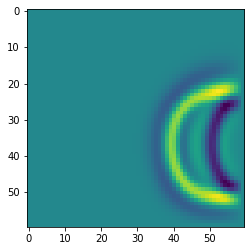

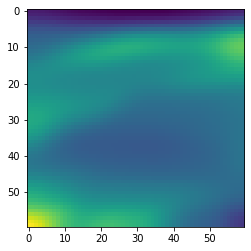

5.120974100221997


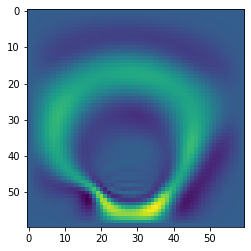

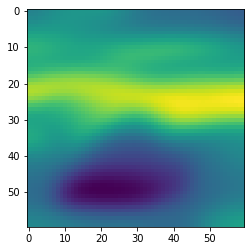

4.907695922180548


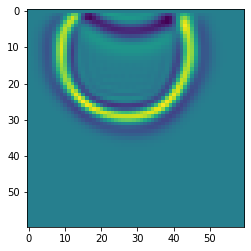

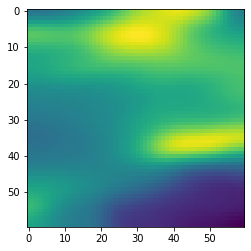

4.483581030636154


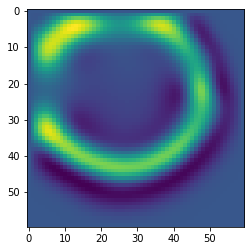

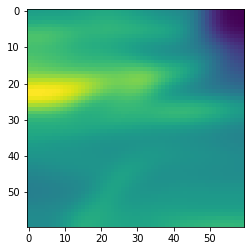

4.71754758669811


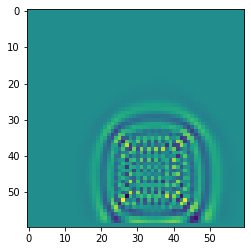

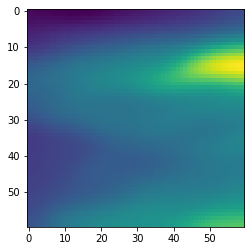

4.720898949425393


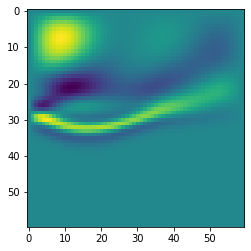

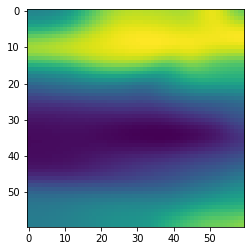

4.029835046315403


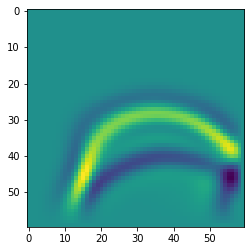

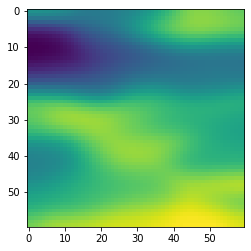

In [76]:
for i in range(100):
  print('==============================================')
  bat = get_batch(1)
  print(bat[1][0][0].min() / ( bat[-1] * bat[-2]))
  plt.imshow(bat[0][0][198])
  plt.show()
  plt.imshow(bat[1][0][0])
  plt.show()


In [77]:
def show_grig(img_batch, n_rows, ):
    batch_size = img_batch.shape[0]
    
    assert batch_size == n_rows ** 2
    
    plt.figure(figsize=(20, 20))
    for i in range(batch_size):
        plt.subplot(n_rows, n_rows, i + 1)
        plt.imshow(img_batch[i])
    plt.show()
    


In [96]:
n_rows = 4
batch = get_batch(n_rows ** 2)

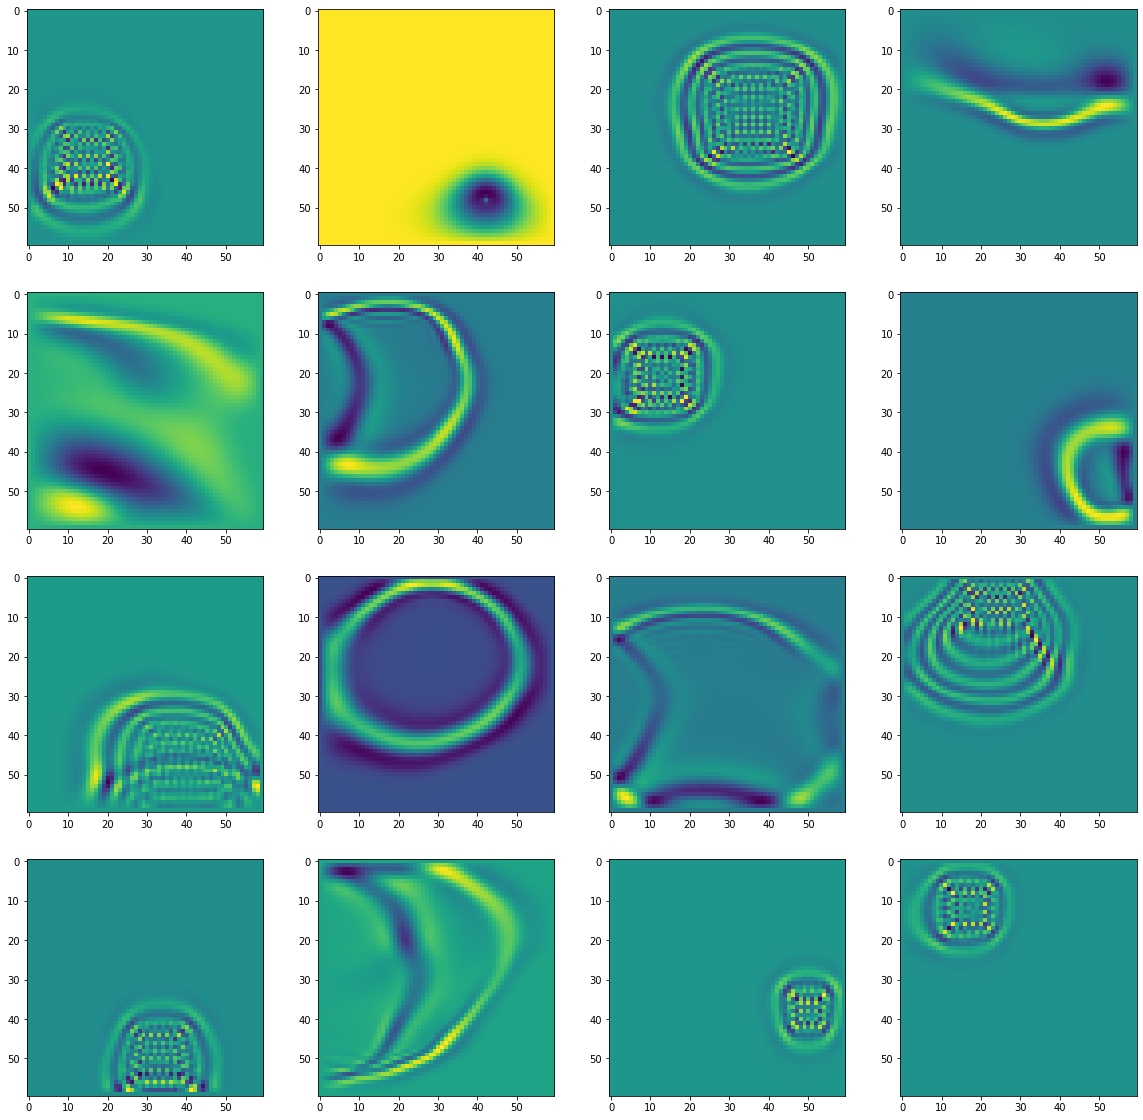

In [97]:
show_grig(batch[0][:, -1, :, :], n_rows)

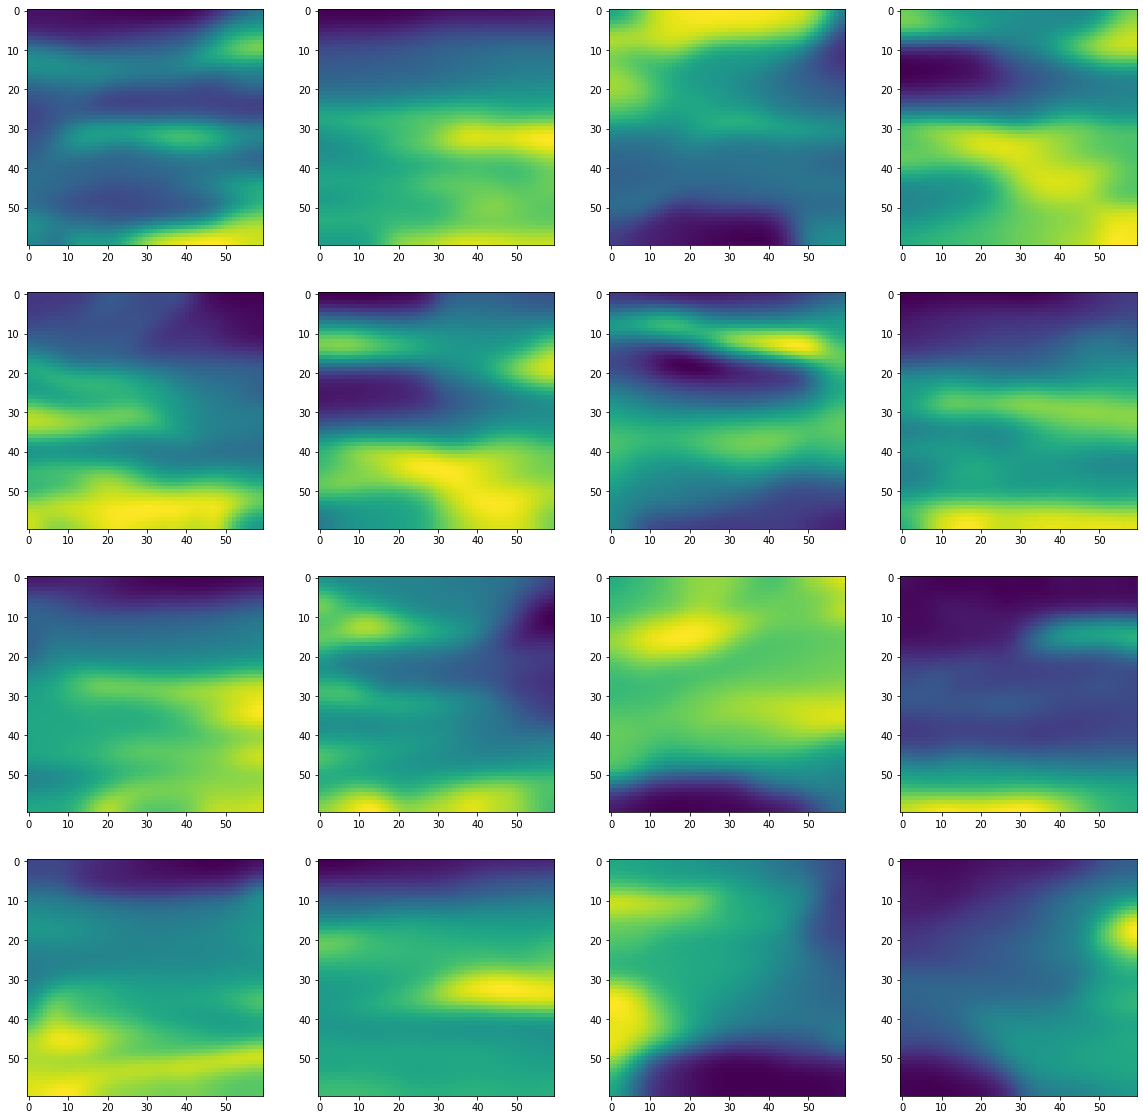

In [83]:
show_grig(batch[1][:, 0, :, :], n_rows)

In [198]:
bat[0][0].max()

272.31120529366547

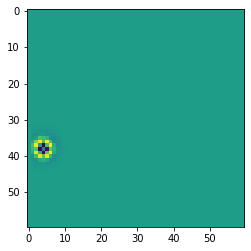

In [199]:
plt.imshow(bat[0][0][189]*1e+8)

In [185]:
(bat[0][0]*1e+8).max()

36.237828283376444

In [25]:

import torch, torch.nn as nn
import torch.nn.functional as F

In [74]:
from conv_gru import ConvGRU

class Encoder(nn.Module):
  def __init__(self, in_channels=1, out_channels=32, kernel_size=3, activation=nn.Softplus):
    super(Encoder, self).__init__()
    
    self.model = nn.Sequential(nn.Conv2d(in_channels, out_channels // 2, kernel_size=kernel_size, padding=1), 
                                 nn.AvgPool2d(2), 
                                 activation(), 
                                 
                                 nn.BatchNorm2d(out_channels // 2),

                                 nn.Conv2d(out_channels // 2, out_channels, kernel_size=kernel_size, padding=1), 
                                 nn.AvgPool2d(2), 
                                 activation(),
                                 
                                 nn.BatchNorm2d(out_channels)
                                 )

  
  def forward(self, input):
    return self.model(input)

class Decoder(nn.Module):
  def __init__(self, in_channels=32, out_channels=1, kernel_size=3, activation=nn.Softplus):
    super(Decoder, self).__init__()
    
    self.model = nn.Sequential(nn.BatchNorm2d(in_channels),
                                
                               activation(), 
                               nn.Upsample(scale_factor=2, mode='bilinear'), 
                               nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=kernel_size, padding=1), 

                               nn.BatchNorm2d(in_channels // 2),

                               activation(), 
                               nn.Upsample(scale_factor=2, mode='bilinear'), 
                               nn.ConvTranspose2d(in_channels // 2, out_channels, kernel_size=kernel_size, padding=1),
                               )

  
  def forward(self, input):
    return self.model(input)


class WaveNet(nn.Module):
  def __init__(self, 
               bottle_neck=32, 
               rnn_channels=32,
               kernel_size=3,
               num_layers=1,
               activation=nn.Softplus):
    super(WaveNet, self).__init__()
    
    self.data_to_h0 = Encoder(in_channels=2, out_channels=bottle_neck, 
                              kernel_size=kernel_size, activation=activation)
    self.encoder = Encoder(in_channels=1, out_channels=bottle_neck, 
                           kernel_size=kernel_size, activation=activation)

    self.decoder = Decoder(rnn_channels, out_channels=1, 
                           kernel_size=kernel_size, activation=activation)
    
    self.conv_gru = ConvGRU(input_dim=bottle_neck,
                            hidden_dim=[rnn_channels],
                            kernel_size=(kernel_size, kernel_size),
                            num_layers=num_layers,
                            dtype=torch.FloatTensor,
                            batch_first=True,
                            bias = True,
                            return_all_layers = False)

  
  def seq_to_cnn(self, data):
    shape = data.shape
    return data.reshape(shape[0] * shape[1], *shape[2:])

  
  def forward(self, solutions, eq_features):
    #print(eq_features.shape)
    initial_hid = self.data_to_h0(eq_features)
    #print(initial_hid.shape)
    shape = solutions.shape

    x = self.encoder(self.seq_to_cnn(solutions.unsqueeze(2)))
    x = x.view(shape[0], shape[1], x.shape[1], x.shape[2], x.shape[3])
    #print(x.shape)
    #print(initial_hid.shape)

    output, _ = self.conv_gru(x, initial_hid)
    x = output[0]
    x = self.decoder(self.seq_to_cnn(x))
    
    #print(x.shape)
    
    return x.view(shape[0], shape[1], x.shape[1], x.shape[2], x.shape[3]).squeeze(2)


In [75]:
device = 'cpu' if not torch.cuda.is_available() else 'cuda'
device

'cuda'

In [170]:
import GPUtil


model = WaveNet(activation=nn.ELU)
model.to(device)

#loss = nn.MSELoss()
loss = nn.L1Loss()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)#, weight_decay=1e-3)

GPUtil.showUtilization()

| ID | GPU | MEM |
------------------
|  0 |  0% | 82% |


In [171]:
batch_size = 15
n_epochs = 200
n_batches_per_epoch = 10
n_validation_batches = 5


Epoch: 3, train loss: inf, val loss: inf


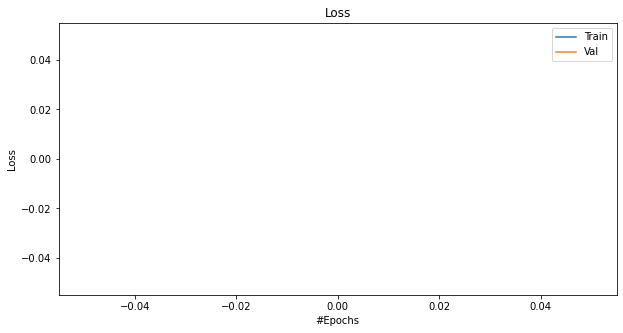

| ID | GPU | MEM |
------------------
|  0 |  0% | 82% |
| ID | GPU | MEM |
------------------
|  0 | 17% | 82% |
| ID | GPU | MEM |
------------------
|  0 | 30% | 82% |
| ID | GPU | MEM |
------------------
|  0 | 21% | 82% |
| ID | GPU | MEM |
------------------
|  0 | 15% | 82% |
| ID | GPU | MEM |
------------------
|  0 | 21% | 82% |
| ID | GPU | MEM |
------------------
|  0 | 80% | 82% |
| ID | GPU | MEM |
------------------
|  0 |  7% | 82% |
| ID | GPU | MEM |
------------------
|  0 | 77% | 82% |
| ID | GPU | MEM |
------------------
|  0 |  7% | 82% |
| ID | GPU | MEM |
------------------
|  0 | 64% | 82% |
| ID | GPU | MEM |
------------------
| ID | GPU | MEM |
------------------
|  0 | 40% | 82% |
| ID | GPU | MEM |
------------------
|  0 | 21% | 82% |
| ID | GPU | MEM |
------------------
|  0 | 19% | 82% |
| ID | GPU | MEM |
------------------
|  0 | 21% | 82% |
| ID | GPU | MEM |
------------------
|  0 | 80% | 82% |
| ID | GPU | MEM |
------------------
|  0 |  6% |

KeyboardInterrupt: ignored

In [172]:
from tqdm.notebook import tqdm
from IPython.display import clear_output

loss_hist = {'train': [],
             'val': []}

for epoch in tqdm(range(n_epochs)):
    
    train_loss=0
    model.train(True)
    for _ in tqdm(range(n_batches_per_epoch)):
        batch = get_batch(3)
        optimizer.zero_grad()
        
        
        GPUtil.showUtilization()
        predictions = model(torch.tensor(batch[0], dtype=torch.float32).to(device), 
                            torch.tensor(batch[1], dtype=torch.float32).to(device))
        loss_t = loss(predictions, torch.tensor(batch[2], dtype=torch.float32).to(device))
        
        GPUtil.showUtilization()
        #print(loss_t)
        #print(predictions)
        loss_t.backward()
        optimizer.step()
        
        train_loss += loss_t.item()
        
    train_loss /= n_batches_per_epoch
    
    loss_hist['train'].append(train_loss)
    
    val_loss=0
    model.train(False)
    for _ in tqdm(range(n_validation_batches)):
        batch = get_batch(batch_size)
        predictions = model(torch.tensor(batch[0], dtype=torch.float32).to(device), 
                            torch.tensor(batch[1], dtype=torch.float32).to(device))
        loss_t = loss(predictions, torch.tensor(batch[2], dtype=torch.float32).to(device))
        val_loss += loss_t.item()
    val_loss /= n_validation_batches
    
    loss_hist['val'].append(val_loss)
    
    if epoch !=0:
      clear_output()
      print('\nEpoch: {}, train loss: {}, val loss: {}'.format(epoch, train_loss, val_loss))
      plt.figure(figsize=(10, 5))
      plt.plot(loss_hist['train'], label='Train')
      plt.plot(loss_hist['val'], label='Val')
      plt.xlabel('#Epochs')
      plt.ylabel('Loss')
      plt.title('Loss')
      plt.legend(loc='best')
      plt.show()

print("Finished!")

In [79]:
for i in range(10):
  print(get_batch(1)[0].max())

0.09699004275653193
0.0028017354028249484
0.0
0.007794346650506785
0.0031739310891792166
0.015437629017600343
0.029208733199011558
0.0
0.0
0.015167622413150452


In [23]:
import gc
del model
gc.collect()
torch.cuda.empty_cache()

In [24]:
GPUtil.showUtilization()

| ID | GPU | MEM |
------------------
|  0 |  0% | 96% |


In [ ]:
batch[0].max()

1.247313496499323e-07